In [6]:
import bokeh

In [7]:
import networkx as nx

In [8]:
#nx.write_gpickle(G, "second_network_w_weights_listversion_wrealnames_v2.gpickle")
G = nx.read_gpickle("second_network_w_weights_listversion_wrealnames_v2.gpickle")

This code is from:
https://gist.github.com/marquisthunder/ed690b132a7c655b4152bbcd7d84ed15

In [ ]:
https://gist.github.com/marquisthunder/ed690b132a7c655b4152bbcd7d84ed15

In [109]:
#https://gist.github.com/marquisthunder/ed690b132a7c655b4152bbcd7d84ed15
import networkx as nx
from collections import namedtuple
from math import sqrt
import bokeh
from bokeh.models import HoverTool
from bokeh.plotting import show, figure
from bokeh.colors import RGB
import random

#corresponding package on pypi is confusingly called python-louvain
import community


def create_bokeh_graph(graph):
    
    #Rykket op! og
    communs = community.best_partition(graph)
    
    pos = community_layout(graph, communs)
    
    
    def gen_edge_coordinates(graph, layout):
        xs = []
        ys = []
        val = namedtuple("edges", "xs ys")
        for edge in graph.edges():
            from_node = layout[edge[0]]
            to_node = layout[edge[1]]
            xs.append([from_node[0],to_node[0]])
            ys.append([from_node[1], to_node[1]])
        return val(xs=xs, ys=ys)
    
    
    
    

    def gen_node_coordinates(layout):
        names, coords = zip(*layout.items())
        xs, ys = zip(*coords)
        val = namedtuple("nodes", "names xs ys")
        return val(names=names, xs=xs, ys=ys)
    
    #Calc Layout - Slowest Part
   # plot_layout = nx.kamada_kawai_layout(graph, 
                                       #  pos=pos # Lau implemtation
                               # k=1/(sqrt(graph.number_of_nodes() * 0.75)),
                                #iterations=600,
                                #scale = 2
                                #        )
    
    
    plot_layout = nx.spring_layout(graph,
                                k=1/(sqrt(graph.number_of_nodes() * 0.75)),
                                iterations=600,
                                scale = 2)
    
    _nodes = gen_node_coordinates(plot_layout)
    _edges = gen_edge_coordinates(graph, plot_layout)
    

    
    #Prepare Bokeh-Figure
    hover = HoverTool(tooltips=[('name', '@name'), 
                                #('node_id', '$index'),
                                #('degree', '@degree'),
                                #('betweenness centrality', '@betweenness'),
                                #('clustering', '@clustering'),
                                ('cluster_nr', '@community_nr')], names=["show_hover"])

    fig = figure(width=800, height=600, 
                 tools=[hover, 'box_zoom', 'reset', 'wheel_zoom', 'pan', 'lasso_select'],
                )
    fig.toolbar.logo = None
    fig.axis.visible = False                            
    fig.xgrid.grid_line_color = None
    fig.ygrid.grid_line_color = None
    
    #Draw Edges
    source_edges = bokeh.models.ColumnDataSource(dict(xs=_edges.xs, ys=_edges.ys))
    fig.multi_line('xs', 'ys', line_color='navy', source=source_edges, alpha=0.05)
    
    #Calc numbers
    degrees = list(dict(graph.degree()).values())
    clustering = list(nx.clustering(graph).values())
    
    
    #nodes, communities = zip(*communs.items())
    nodes, communities = zip(*communs.items())
    betw = list(nx.betweenness_centrality(graph).values())
    
    #create Colormaps
    colormap_coms = {x : RGB(random.randrange(0,256),random.randrange(0,256),random.randrange(0,256)) 
                     for x in list(set(communities))}
    community_color_list, community_nr = zip(*[(colormap_coms[communs[node]], communs[node]) for node in nodes])

    
    graph_nodes = graph.number_of_nodes()
    
    colors = ['firebrick' for node in range(graph_nodes)]
    
    #Draw circles
    source_nodes = bokeh.models.ColumnDataSource(dict(xs=_nodes.xs, ys=_nodes.ys, name=_nodes.names, 
                                                      single_color = colors,
                                                      color_by_community = community_color_list, 
                                                      degree=degrees, 
                                                      clustering=clustering, 
                                                      community_nr=community_nr,
                                                      betweenness = betw
                                                     ))
    
    r_circles = fig.circle('xs', 'ys', fill_color='single_color', line_color='single_color', 
                           source = source_nodes, alpha=0.7, size=9, name="show_hover")
    
    #r_circles = fig.circle('xs', 'ys', fill_color='color_by_community', line_color='color_by_community', 
     #                      source = source_nodes, alpha=0.7, size=9, name="show_hover")
    
    #Create Color-Selector    
    colorcallback = bokeh.models.callbacks.CustomJS(args=dict(source=source_nodes, circles=r_circles), code="""
        var value = cb_obj.get('value');
        circles.glyph.line_color.field = value;
        circles.glyph.fill_color.field = value;
        source.trigger('change')
    """)  
    
    #button = bokeh.models.widgets.Select(title="Color", value="single_color", 
    #                                     options=["single_color", "color_by_community"], 
    #                                     callback=colorcallback)
    
    #Create grid and save
   # layout_plot = bokeh.layouts.gridplot([[fig, button]])
    layout_plot = bokeh.layouts.gridplot([[fig]])
    
    #if file is wanted
    bokeh.io.output_file(f"graph"+str(np.random.randint(low=0, high=1000))+".html")
    bokeh.io.save(layout_plot)
    
    show(layout_plot)
  #  return fig

In [30]:
G_undirected=G.to_undirected()

In [31]:
Gcc = sorted(nx.weakly_connected_components(G), key=len, reverse=True)
giant_directed=G.subgraph(Gcc[0])
giant = G_undirected.subgraph(Gcc[0])
d = dict(giant.degree) #Saves the degree for making the nodesize depended of the degreee in plots

In [32]:
#HAR SAT DETTE IND I SELVE FUNKTIONEN
#g = giant
#partition = community.best_partition(g)
#pos = community_layout(g, partition)

In [101]:
create_bokeh_graph(giant)

In [ ]:
# Lav eventuel to tabs, en med color by community o

## Extracting only the largest communities

In [102]:
from collections import Counter
partition = community.best_partition(giant)
a=np.array(list(partition.values()))
b = Counter(a)

#Extracting the number of nodes in each commnuity
community_sizes=[i[1] for i in b.most_common(17)]

largest_communities=[i for i in b.most_common(8)]

In [103]:
have_with=[k for k in list(partition.keys()) if partition[k] in [i[0] for i in largest_communities] ]

In [104]:
giant2=giant.subgraph([k for k in list(partition.keys()) if partition[k] in [i[0] for i in largest_communities] ])

In [110]:
create_bokeh_graph(giant2)

In [ ]:
tab1 = Panel(child=p1, title="circle")
tab2 = Panel(child=p2, title="line")
tabs = Tabs(tabs=[ tab1, tab2 ])
show(tabs)

# Manuel måde at lave et plot af communities

In [ ]:
https://stackoverflow.com/questions/43541376/how-to-draw-communities-with-networkx

In [94]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

def community_layout(g, partition):
    """
    Compute the layout for a modular graph.


    Arguments:
    ----------
    g -- networkx.Graph or networkx.DiGraph instance
        graph to plot

    partition -- dict mapping int node -> int community
        graph partitions


    Returns:
    --------
    pos -- dict mapping int node -> (float x, float y)
        node positions

    """

    pos_communities = _position_communities(g, partition, scale=3.)

    pos_nodes = _position_nodes(g, partition, scale=1.)

    # combine positions
    pos = dict()
    for node in g.nodes():
        pos[node] = pos_communities[node] + pos_nodes[node]

    return pos

def _position_communities(g, partition, **kwargs):

    # create a weighted graph, in which each node corresponds to a community,
    # and each edge weight to the number of edges between communities
    between_community_edges = _find_between_community_edges(g, partition)

    communities = set(partition.values())
    hypergraph = nx.DiGraph()
    hypergraph.add_nodes_from(communities)
    for (ci, cj), edges in between_community_edges.items():
        hypergraph.add_edge(ci, cj, weight=len(edges))

    # find layout for communities
    pos_communities = nx.spring_layout(hypergraph, **kwargs)

    # set node positions to position of community
    pos = dict()
    for node, community in partition.items():
        pos[node] = pos_communities[community]

    return pos

def _find_between_community_edges(g, partition):

    edges = dict()

    for (ni, nj) in g.edges():
        ci = partition[ni]
        cj = partition[nj]

        if ci != cj:
            try:
                edges[(ci, cj)] += [(ni, nj)]
            except KeyError:
                edges[(ci, cj)] = [(ni, nj)]

    return edges

def _position_nodes(g, partition, **kwargs):
    """
    Positions nodes within communities.
    """

    communities = dict()
    for node, community in partition.items():
        try:
            communities[community] += [node]
        except KeyError:
            communities[community] = [node]

    pos = dict()
    for ci, nodes in communities.items():
        subgraph = g.subgraph(nodes)
        pos_subgraph = nx.spring_layout(subgraph, **kwargs)
        pos.update(pos_subgraph)

    return pos

def test():
    # to install networkx 2.0 compatible version of python-louvain use:
    # pip install -U git+https://github.com/taynaud/python-louvain.git@networkx2
    from community import community_louvain

    g = giant2
    partition = community_louvain.best_partition(g)
    pos = community_layout(g, partition)
    d = dict(g.degree(g.nodes()))

    plt.figure(figsize=(20,10))
    #nx.draw(g, pos,alpha=0.5, node_color=list(partition.values()),node_size=[v * 10 for v in d.values()]); plt.show()
    
    nx.draw_networkx_edges(g, pos, alpha=0.1)
    nx.draw_networkx_nodes(g, pos, alpha=0.9,node_size=50,node_color=list(partition.values()))
    #nx.draw_networkx_nodes(g, pos, alpha=0.35,node_color=list(partition.values()),node_size=[v * 3 for v in d.values()])
    
    
    return

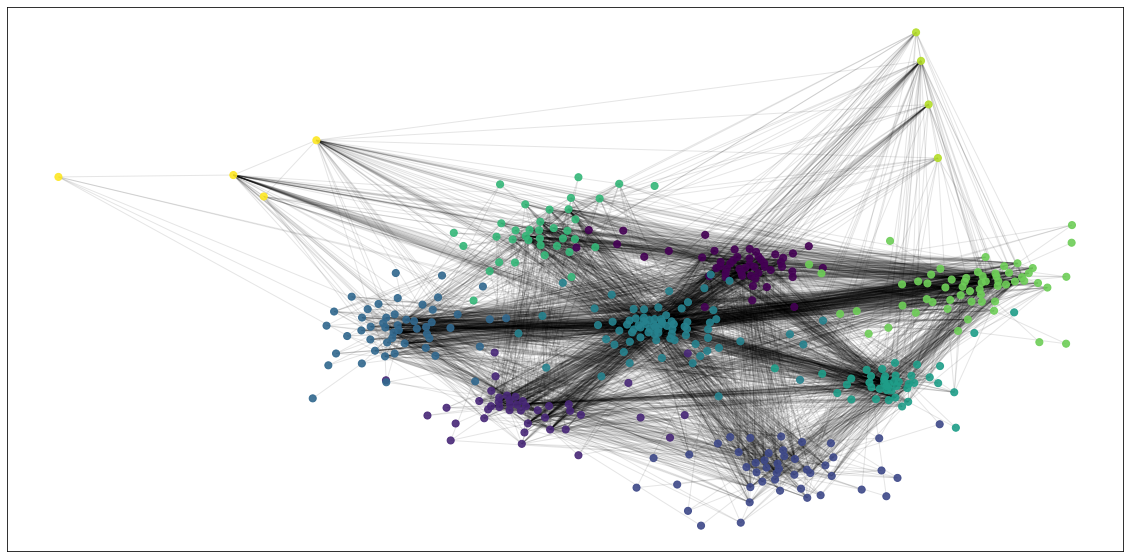

In [95]:
test()

In [ ]:
#https://gist.github.com/marquisthunder/ed690b132a7c655b4152bbcd7d84ed15
import networkx as nx
from collections import namedtuple
from math import sqrt
import bokeh
from bokeh.models import HoverTool
from bokeh.plotting import show, figure
from bokeh.colors import RGB
import random

#corresponding package on pypi is confusingly called python-louvain
import community


def create_bokeh_graph(graph):
    
    def gen_edge_coordinates(graph, layout):
        xs = []
        ys = []
        val = namedtuple("edges", "xs ys")
        for edge in graph.edges():
            from_node = layout[edge[0]]
            to_node = layout[edge[1]]
            xs.append([from_node[0],to_node[0]])
            ys.append([from_node[1], to_node[1]])
        return val(xs=xs, ys=ys)

    def gen_node_coordinates(layout):
        names, coords = zip(*layout.items())
        xs, ys = zip(*coords)
        val = namedtuple("nodes", "names xs ys")
        return val(names=names, xs=xs, ys=ys)
    
    #Calc Layout - Slowest Part
    plot_layout = nx.kamada_kawai_layout(graph,
                                #k=1/(sqrt(graph.number_of_nodes() * 0.75)),
                                #iterations=60,
                                #scale = 2
                                        )
    
   # plot_layout = nx.kamada_kawai_layout(graph,
    #                            k=1/(sqrt(graph.number_of_nodes() * 0.75)),
    #                            iterations=60,
    #                            scale = 2)
    
    _nodes = gen_node_coordinates(plot_layout)
    _edges = gen_edge_coordinates(graph, plot_layout)
    
    #Prepare Bokeh-Figure
    hover = HoverTool(tooltips=[('name', '@name'), 
                                #('node_id', '$index'),
                                #('degree', '@degree'),
                                #('betweenness centrality', '@betweenness'),
                                #('clustering', '@clustering'),
                                ('cluster_nr', '@community_nr')], names=["show_hover"])

    fig = figure(width=800, height=600, 
                 tools=[hover, 'box_zoom', 'reset', 'wheel_zoom', 'pan', 'lasso_select'],
                )
    fig.toolbar.logo = None
    fig.axis.visible = False                            
    fig.xgrid.grid_line_color = None
    fig.ygrid.grid_line_color = None
    
    #Draw Edges
    source_edges = bokeh.models.ColumnDataSource(dict(xs=_edges.xs, ys=_edges.ys))
    fig.multi_line('xs', 'ys', line_color='navy', source=source_edges, alpha=0.17)
    
    #Calc numbers
    degrees = list(dict(graph.degree()).values())
    clustering = list(nx.clustering(graph).values())
    communs = community.best_partition(graph)
    nodes, communities = zip(*communs.items())
    betw = list(nx.betweenness_centrality(graph).values())
    
    #create Colormaps
    colormap_coms = {x : RGB(random.randrange(0,256),random.randrange(0,256),random.randrange(0,256)) 
                     for x in list(set(communities))}
    community_color_list, community_nr = zip(*[(colormap_coms[communs[node]], communs[node]) for node in nodes])

    
    graph_nodes = graph.number_of_nodes()
    
    colors = ['firebrick' for node in range(graph_nodes)]
    
    #Draw circles
    source_nodes = bokeh.models.ColumnDataSource(dict(xs=_nodes.xs, ys=_nodes.ys, name=_nodes.names, 
                                                      single_color = colors,
                                                      color_by_community = community_color_list, 
                                                      degree=degrees, 
                                                      clustering=clustering, 
                                                      community_nr=community_nr,
                                                      betweenness = betw
                                                     ))
    
    #r_circles = fig.circle('xs', 'ys', fill_color='single_color', line_color='single_color', 
    #                       source = source_nodes, alpha=0.7, size=9, name="show_hover")
    
    r_circles = fig.circle('xs', 'ys', fill_color='color_by_community', line_color='color_by_community', 
                           source = source_nodes, alpha=0.7, size=9, name="show_hover")
    
    #Create Color-Selector    
    colorcallback = bokeh.models.callbacks.CustomJS(args=dict(source=source_nodes, circles=r_circles), code="""
        var value = cb_obj.get('value');
        circles.glyph.line_color.field = value;
        circles.glyph.fill_color.field = value;
        source.trigger('change')
    """)  
    
    button = bokeh.models.widgets.Select(title="Color", value="single_color", 
                                         options=["single_color", "color_by_community"], 
                                         callback=colorcallback)
    
    #Create grid and save
    layout_plot = bokeh.layouts.gridplot([[fig, button]])
    
    #if file is wanted
    #bokeh.io.output_file(f"graph.html")
    #bokeh.io.save(layout_plot)
    
    show(layout_plot)